# Micromagnetic standard problem 1

**Authors**: Marijan Beg, Ryan A. Pepper, and Hans Fangohr

**Date**: 12 December 2016

## Problem specification

The simulated sample is a thin film cuboid with dimensions:

- length $l_{x} =  2 \,\mu\text{m}$,
- width $l_{y} = 1 \,\mu\text{m}$, and
- thickness $l_{z} = 20 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Apart from the symmetric exchange and demagnetisation energies, uniaxial anisotropy energy is also present with

- $K = 0.5 \times 10^{3} \,\text{J/m}^{3}$ and
- $\mathbf{u} = (1, 0, 0)$.

More details on standard problem 1 specifications can be found in Ref. 1.

## Load nanoHUB module


In [1]:
import hublib.use
%use oommf-1.2b0

In [2]:
# We need this because this example is running in a read-only directory.
# You should not normally do this.
import os
try:
    os.mkdir('/tmp/oommf')
except:
    pass
os.chdir('/tmp/oommf')

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [3]:
import discretisedfield as df
import oommfc as oc

Now, we can set all required geometry and material parameters.

In [4]:
# Geometry
lx = 2e-6  # x dimension of the sample(m)
ly = 1e-6  # y dimension of the sample (m)
lz = 20e-9  # sample thickness (m)

# Material parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
K = 0.5e3  # uniaxial anisotropy constant (J/m**3)
u = (1, 0, 0)  # uniaxial anisotropy axis

Now, we can create a system object with `stdprob1` name.

In [5]:
system = oc.System(name="stdprob1")

In order to completely define the micromagnetic system, we need to provide:

1. hamiltonian $\mathcal{H}$
2. dynamics $\text{d}\mathbf{m}/\text{d}t$
3. magnetisation $\mathbf{m}$

**Hamiltonian:** In the next step, we add energy terms to the Hamiltonian. We add exchange, demagnetisation, and uniaxial anisotropy terms. Although we need to simulate the hysteresis loop with applied magnetic field, we do not add the Zeeman energy contribution to the Hamilotnian because the driver will take care of that.

In [6]:
system.hamiltonian = oc.Exchange(A) + oc.UniaxialAnisotropy(K, u) + oc.Demag()
system.hamiltonian

Exchange(A=1.3e-11, name="exchange") + UniaxialAnisotropy(K1=500.0, K2=0, u=(1, 0, 0), name="uniaxialanisotropy") + Demag(name="demag")

**Dynamics:** In this standard problem, we do not care about the magnetisation dynamics. All we need is the minimum energy magnetisation configuration. Because of that, we will be using the `MinDriver` which does not need dynamics equation to be specified.

In [7]:
system.dynamics

**Magnetisation:** The system is initialised in the $(10, 1, 0)$ direction [1]. Firstly, we create the mesh by providing two points `p1` and `p2` between which the mesh domain spans and the size of a discretisation cell. We choose the discretisation to be $(20, 20, 20) \,\text{nm}$.

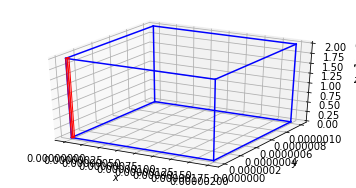

In [8]:
%matplotlib inline

# Create a mesh object.
mesh = oc.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=(20e-9, 20e-9, 20e-9))
mesh

Now, the magnetisation field can be fefined.

In [9]:
system.m = df.Field(mesh, value=(-10, -1, 0), norm=Ms)

**Hysteresis simulation:** Before the hysteresis simulations are carried out, maximum and minimum external magnetic field values at which the system should be relaxed must be created. These values are taken from the standard problem specification [1]. Also, we specify that between $H_\text{min}$ and $H_\text{max}$ we want $n=50$ steps.

In [10]:
Hmax = (50e-3/oc.mu0, 0.87275325e-3/oc.mu0, 0)
Hmin = (-50e-3/oc.mu0, -0.87275325e-3/oc.mu0, 0)
n = 50

Finally, we drive the system using `HysteresisDriver`.

In [11]:
hd = oc.HysteresisDriver()
hd.drive(system, Hmax=Hmax, Hmin=Hmin, n=n)

2018/5/27 19:41: Calling OOMMF (stdprob1/stdprob1.mif) ... [96.3s]


## Hysteresis loop plot

After obtaining the average magnetisation at different external magnetic field values, hysteresis loop is plotted. In this tutorial, we extract the x component of magnetisation and external magnetic field from the system's datatable and plot it using `matplotlib`.

Text(0,0.5,'mx')

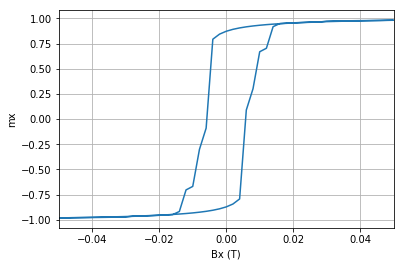

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

Bx = system.dt["Bx"].values
mx = system.dt["mx"].values

plt.plot(Bx*1e-3, mx)
plt.grid()
plt.xlim([Hmin[0]*oc.mu0, Hmax[0]*oc.mu0])
plt.xlabel("Bx (T)")
plt.ylabel("mx")

## References

[1] µMAG Site Directory: http://www.ctcms.nist.gov/~rdm/mumag.org.html

<hr>
Cleaning up.  Temporary files were written.  You may want to remove them.

In [13]:
!rm -rf stdprob1